In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler

In [31]:
# Use GPU if available, else use CPU
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


In [32]:
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # GRU cell
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers = 1, batch_first = True)
        # Output layer
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hidden):
        # Forward pass through the GRU cell
        out, new_hidden = self.gru(inputs, hidden)
        # Apply the output layer 
        output = self.linear(out)
        return new_hidden, output

In [33]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=1024, num_layers=4, output_size=1):
        super().__init__()
        self.gru = nn.GRU(input_size,
                          hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          dropout=0.1)
        self.bn  = nn.BatchNorm1d(hidden_size)
        self.fc  = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        # x: [batch, seq_len, input_size]
        # h0: [num_layers, batch, hidden_size] (optional; zeros if None)
        out, hn = self.gru(x, h0)
        # take last time‑step's output:
        last = out[:, -1, :]              # [batch, hidden_size]
        last = self.bn(last)             # optional
        return self.fc(last), hn         # returns (predictions, new_hidden)


In [34]:
#data preprocessing
econ_sentiment_data = 'data/economic_sentiment_dataset.csv'
fin_stab_data = 'data/financial_stability_dataset.csv'
full_mac_data = 'data/full_macro_data.csv'
merged_dataset = 'data/merged_dataset.csv'

#The datasets before merged_dataset were not used individually, but they're there to show the raw datasets which made up the eventual merged_dataset
df4 = pd.read_csv(merged_dataset)
df4

,DATE,REAINTRATREARAT10Y,CORESTICKM159SFRBATL,CPILFESL,EXPINF30YR,FPCPITOTLZGUSA,GDP,unrate,psr,m2,...,tcs,indpro,ccpi,PCEPILFE,Price,Open,High,Low,Change %,value
0,1947-01-01,7.623742,3.651861,28.500,5.067615,1.457976,243.164,7.5,10.9,1612.90,...,458080.0,51.1668,85.400,15.501,108.77,109.33,109.65,108.64,-0.72%,21.480
1,1947-02-01,7.623742,3.651861,28.500,5.067615,1.457976,243.164,7.5,10.9,1612.90,...,458080.0,51.1668,85.400,15.501,108.77,109.33,109.65,108.64,-0.72%,21.620
2,1947-03-01,7.623742,3.651861,28.500,5.067615,1.457976,243.164,7.5,10.9,1612.90,...,458080.0,51.1668,85.400,15.501,108.77,109.33,109.65,108.64,-0.72%,22.000
3,1947-04-01,7.623742,3.651861,28.500,5.067615,1.457976,245.968,7.5,10.9,1612.90,...,458080.0,51.1668,85.400,15.501,108.77,109.33,109.65,108.64,-0.72%,22.000
4,1947-05-01,7.623742,3.651861,28.500,5.067615,1.457976,245.968,7.5,10.9,1612.90,...,458080.0,51.1668,85.400,15.501,108.77,109.33,109.65,108.64,-0.72%,21.950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6378,2024-11-01,1.439817,3.876177,322.619,2.455171,4.116338,26465.865,4.6,7.3,21152.35,...,1598020.0,101.7610,281.695,123.724,110.12,109.54,110.23,109.36,0.53%,303.841
6379,2024-12-01,1.439817,3.746553,323.296,2.442309,4.116338,26465.865,4.6,7.3,21152.35,...,1598020.0,101.7610,281.695,123.981,110.12,109.54,110.23,109.36,0.53%,303.841
6380,2025-01-01,1.439817,3.625276,324.739,2.523400,4.116338,26465.865,4.6,7.3,21152.35,...,1598020.0,101.7610,281.695,124.334,110.12,109.54,110.23,109.36,0.53%,303.841
6381,2025-02-01,1.439817,3.516515,325.475,2.536097,4.116338,26465.865,4.6,7.3,21152.35,...,1598020.0,101.7610,281.695,124.334,110.12,109.54,110.23,109.36,0.53%,303.841


In [35]:
df4['DATE'] = pd.to_datetime(df4['DATE'])

#Extract year, month, and day as separate features. Idea behind this is to help the model notice seasonal patterns
df4['Year'] = df4['DATE'].dt.year
df4['Month'] = df4['DATE'].dt.month
df4['Day'] = df4['DATE'].dt.day

#Drop date column
df4.drop(columns=['DATE'], inplace=True)
df4.drop(df4.index[0:649]) #Start with 2000 to avoid overrepresentation of a time when interest rate data was scarce
df4.drop(columns=['Change %'], inplace=True) 
df4['change_percent'] = (df4['ir'] - df4['ir'].shift(1))/df4['ir'].shift(1) #Current - Previous; does not assume future knowledge
df4['change_percent'] = df4['change_percent'].fillna(0) #Change% dropped and replaced with changed_percent as values were innaccurate at times

scaler = RobustScaler()
ir_scaler = RobustScaler()

cols_to_scale = df4.columns.difference(['ir']).drop(df4.columns[-1])

robust_df = df4.copy()
robust_df[cols_to_scale] = scaler.fit_transform(df4[cols_to_scale])
robust_df['ir'] = ir_scaler.fit_transform(df4[['ir']])
robust_df.head

<bound method NDFrame.head of       REAINTRATREARAT10Y  CORESTICKM159SFRBATL  CPILFESL  EXPINF30YR  \
0               4.485015              1.428104 -3.700662    5.278550   
1               4.485015              1.428104 -3.700662    5.278550   
2               4.485015              1.428104 -3.700662    5.278550   
3               4.485015              1.428104 -3.700662    5.278550   
4               4.485015              1.428104 -3.700662    5.278550   
...                  ...                   ...       ...         ...   
6378            0.272809              1.689196  1.929271    0.253605   
6379            0.272809              1.538321  1.942230    0.228866   
6380            0.272809              1.397161  1.969852    0.384842   
6381            0.272809              1.270569  1.983940    0.409264   
6382            0.272809              1.270569  1.983940    0.231246   

      FPCPITOTLZGUSA       GDP    unrate       psr        m2     dspic  ...  \
0          -0.517007 -2.26

In [36]:
#Setting up features and labels
target = 'ir'
feats = robust_df.drop(columns=[target]).values
labels = robust_df[target].values.reshape(-1, 1)

X_tensor = torch.tensor(feats, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.float32)

def create_sequences(X, y, window_size):
    sequences_X, sequences_y = [], []
    for i in range(len(X) - window_size):
        sequences_X.append(X[i : i + window_size])  #Take window_size past steps (30)
        sequences_y.append(y[i + window_size])  #Target is the next step after the window
    return torch.stack(sequences_X), torch.stack(sequences_y)

window_size = 30
X_tensor, y_tensor = create_sequences(X_tensor, y_tensor, window_size)

X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5) #Did train_test_split twice to preserve proper proportions of train:val:test

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [37]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
    
class DoubleRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(torch.sqrt(self.mse(yhat,y)))

input_size = X_tensor.shape[2]  
model = GRUModel(input_size)
#model.load_state_dict(torch.load("model_weights_gen5plus.pth", weights_only=True)) #Uncomment to load weights
criterion = DoubleRMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [ ]:
def compute_metrics(loader, model, criterion):
    total_loss, total_mae, total_rmse = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in loader:
            # unpack the tuple (hidden_state, predictions)
            _, preds = model(batch_X, None)
            loss = criterion(preds, batch_y)
            mae  = torch.mean(torch.abs(preds - batch_y)).item()
            rmse = torch.sqrt(torch.mean((preds - batch_y) ** 2)).item()

            total_loss  += loss.item()
            total_mae   += mae
            total_rmse  += rmse

    avg_loss = total_loss  / len(loader)
    avg_mae  = total_mae   / len(loader)
    avg_rmse = total_rmse  / len(loader)
    return avg_loss, avg_mae, avg_rmse


# --- Train Loop ---
epochs            = 200
patience          = 20
best_val_loss     = float("inf")
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    total_train_loss, total_train_mae, total_train_rmse = 0, 0, 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        # unpack the tuple returned by forward
        _, preds = model(batch_X, None)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_mae  += torch.mean(torch.abs(preds - batch_y)).item()
        total_train_rmse += torch.sqrt(torch.mean((preds - batch_y) ** 2)).item()

    train_loss = total_train_loss / len(train_loader)
    train_mae  = total_train_mae  / len(train_loader)
    train_rmse = total_train_rmse / len(train_loader)

    val_loss, val_mae, val_rmse = compute_metrics(val_loader, model, criterion)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.6f}, MAE: {train_mae:.6f}, RMSE: {train_rmse:.6f} | "
          f"Val   Loss: {val_loss:.6f}, MAE: {val_mae:.6f}, RMSE: {val_rmse:.6f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss     = val_loss
        early_stop_counter = 0
        best_model_state   = model.state_dict()
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}.")
        break

# load best and evaluate on test set
model.load_state_dict(best_model_state)
test_loss, test_mae, test_rmse = compute_metrics(test_loader, model, criterion)
print(f"\nFinal Test Results - Loss: {test_loss:.6f}, MAE: {test_mae:.6f}, RMSE: {test_rmse:.6f}")

# save the weights
torch.save(model.state_dict(), "gru_model_weights/model_weights.pth")


/opt/anaconda3/envs/deeplearning/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([4, 512, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/deeplearning/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([474, 1])) that is different to the input size (torch.Size([4, 474, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/deeplearning/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([4, 256, 1024])). This will likely lead to incor

Epoch 1/200 | Train Loss: 1.073784, MAE: 0.709355, RMSE: 1.155521 | Val   Loss: 1.086990, MAE: 0.734814, RMSE: 1.186876
Epoch 2/200 | Train Loss: 1.047774, MAE: 0.664185, RMSE: 1.098934 | Val   Loss: 1.040034, MAE: 0.637056, RMSE: 1.086861
Epoch 3/200 | Train Loss: 1.004345, MAE: 0.563603, RMSE: 1.009582 | Val   Loss: 1.010551, MAE: 0.574656, RMSE: 1.026091
Epoch 4/200 | Train Loss: 0.979624, MAE: 0.523377, RMSE: 0.960583 | Val   Loss: 0.984803, MAE: 0.523752, RMSE: 0.974843
Epoch 5/200 | Train Loss: 0.955410, MAE: 0.475477, RMSE: 0.914544 | Val   Loss: 0.964532, MAE: 0.481911, RMSE: 0.935389
Epoch 6/200 | Train Loss: 0.939349, MAE: 0.442664, RMSE: 0.883174 | Val   Loss: 0.949713, MAE: 0.451887, RMSE: 0.907023
Epoch 7/200 | Train Loss: 0.925779, MAE: 0.414684, RMSE: 0.858049 | Val   Loss: 0.938218, MAE: 0.427313, RMSE: 0.885394
Epoch 8/200 | Train Loss: 0.915949, MAE: 0.395611, RMSE: 0.840111 | Val   Loss: 0.931938, MAE: 0.420810, RMSE: 0.873615
Epoch 9/200 | Train Loss: 0.910977, MAE:

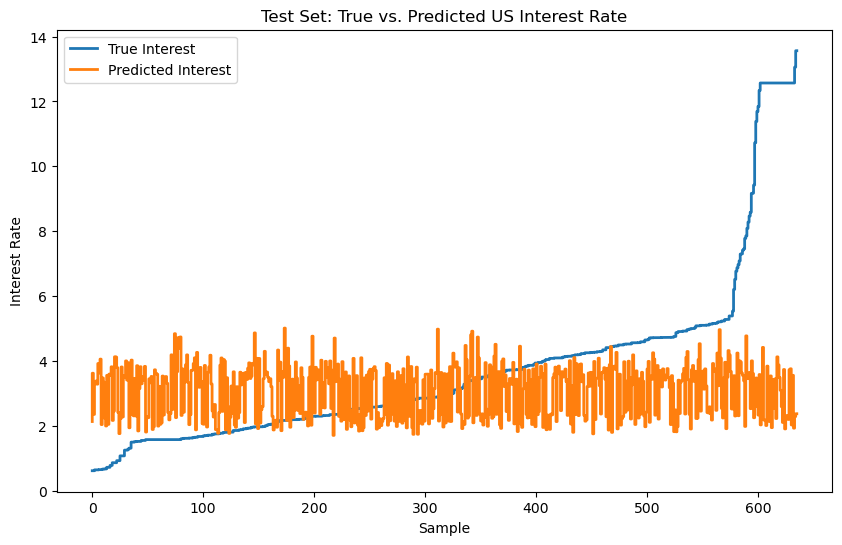

In [ ]:
import matplotlib.pyplot as plt

model.eval()
actuals = []
predictions = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        # 1) unpack hidden and preds
        _, preds = model(batch_X)
        # 2) move to CPU
        preds    = preds.cpu()
        batch_y  = batch_y.cpu()

        actuals.extend(batch_y.numpy().flatten())
        predictions.extend(preds.numpy().flatten())

actuals    = np.array(actuals)
predictions= np.array(predictions)

sorted_idx = np.argsort(actuals)
actuals    = ir_scaler.inverse_transform(actuals[sorted_idx].reshape(-1,1))
predictions= ir_scaler.inverse_transform(predictions[sorted_idx].reshape(-1,1))

plt.figure(figsize=(10, 6))
plt.step(range(len(actuals)),    actuals,    label="True Interest",      linewidth=2)
plt.step(range(len(predictions)),predictions, label="Predicted Interest",   linewidth=2)

plt.xlabel("Sample")
plt.ylabel("Interest Rate")
plt.title("Test Set: True vs. Predicted US Interest Rate")
plt.legend()
plt.show()
